In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)    # torch.rand(shape) 均匀分布

def f(x):
    return 2 * torch.sin(x) + x ** .8

y_train = f(x_train) + torch.normal(.0, .5, size=(n_train, ))   # torch.normal(means, std) 正态分布
x_test = torch.arange(0, 5, .1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    """ 绘制训练/测试/预测样本 """
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])   # 绘制测试、预测样本
    d2l.plt.plot(x_train, y_train, 'o', alpha=.5)   # 绘制训练样本

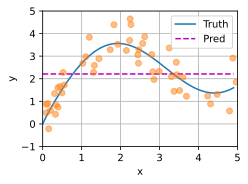

In [13]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)     # y_train.shape  [50]
plot_kernel_reg(y_hat)

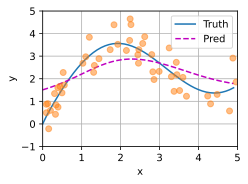

In [18]:
X_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)   # 每一行都包含相同的测试输入（查询）
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)    # 因为X_repeat的每一行都是相同的测试输入，但每一列就是所有的测试输入，所以按dim=1列的方向做softmax. x_train理解为 键，x_repeat理解为 查询
y_hat = torch.matmul(attention_weights, y_train)    # y_train按attention_weights注意力全中的加权平均结果
plot_kernel_reg(y_hat)      # 比平均汇聚的预测更接近真实

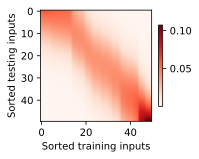

In [19]:
d2l.show_heatmaps(attention_weights[None][None], 'Sorted training inputs', 'Sorted testing inputs')

In [23]:
attention_weights

tensor([[5.7925e-02, 5.7915e-02, 5.7690e-02,  ..., 5.8957e-07, 3.8823e-07,
         2.5884e-07],
        [5.5047e-02, 5.5048e-02, 5.5023e-02,  ..., 8.9658e-07, 5.9552e-07,
         4.0032e-07],
        [5.2126e-02, 5.2136e-02, 5.2291e-02,  ..., 1.3586e-06, 9.1022e-07,
         6.1693e-07],
        ...,
        [2.2720e-06, 2.2913e-06, 2.6833e-06,  ..., 9.1371e-02, 9.0281e-02,
         8.8636e-02],
        [1.5383e-06, 1.5516e-06, 1.8234e-06,  ..., 9.8997e-02, 9.8665e-02,
         9.7669e-02],
        [1.0354e-06, 1.0446e-06, 1.2318e-06,  ..., 1.0663e-01, 1.0720e-01,
         1.0699e-01]])

In [24]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [25]:
weights = torch.ones(size=(2, 10)) * .1
values = torch.arange(20.).reshape(shape=(2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [41]:
class NWKernelRegression(nn.Module):
    """ 核回归的带参版本 """
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
    
    def forward(self, queries, keys, values):
        # print(f'$$$$$$ {queries.shape}\t{keys.shape}\t{values.shape}')    torch.Size([50])	torch.Size([50, 49])	torch.Size([50, 49])
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))     # repeat_interleave每个值重复Keys.shape[1]遍，reshape后每一行都是相同的值
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w) ** 2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [47]:
torch.rand((1,))

tensor([0.4738])

In [37]:
# print(f'$$$$$ x_train.shape:{x_train.shape}\n{x_train}')
X_tile = x_train.repeat((n_train, 1))   # X_train复制n_train行  每一列都是相同的，每一行可是1个x_train
Y_tile = y_train.repeat((n_train, 1))
print(f'X_tile.shape:{X_tile.shape}, Y_tile.shape:{Y_tile.shape}')
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(shape=(n_train, -1))      # X_tile[]索引的意思是不取对角线元素，也就是扔掉50个元素
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

X_tile.shape:torch.Size([50, 50]), Y_tile.shape:torch.Size([50, 50])


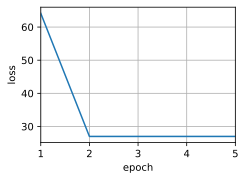

In [48]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch+1, float(l.sum()))

$$$$$$ torch.Size([50])	torch.Size([50, 50])	torch.Size([50, 50])


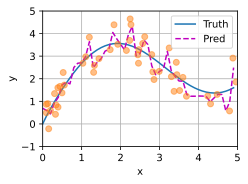

In [49]:
keys = x_train.repeat((n_test, 1))  # keys.shape:(n_test, n_train) 每一行都包含着相同的训练输入，如相同的 键
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

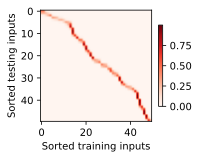

In [50]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')